In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import h5py
import torch
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from fastmri import ifft2c

In [ ]:
directory = "/content/drive/MyDrive/MRI"

In [ ]:
!pip install fastmri

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00


In [ ]:

BATCH_SIZE = 1  
TARGET_SIZE = (320, 640)  
NUM_SPOKES = 90 

def kspace_to_image(kspace_data):
    """Convert k-space data to images using inverse FFT and GPU."""
    kspace_complex = np.stack((np.real(kspace_data), np.imag(kspace_data)), axis=-1)
    kspace_tensor = torch.tensor(kspace_complex, dtype=torch.float32).to("cuda")
    image_tensor = ifft2c(kspace_tensor)
    magnitude_images = torch.abs(image_tensor)
    magnitude_images -= magnitude_images.amin(dim=(-2, -1), keepdim=True)
    magnitude_images /= magnitude_images.amax(dim=(-2, -1), keepdim=True)
    magnitude_images *= 255.0
    return magnitude_images.byte().cpu().numpy()

# Function to combine coil images into one
def combine_images(images):
    """Combine coil images using Root Sum of Squares (RSS)."""
    combined_image = np.sqrt(np.sum(images.astype(np.float32) ** 2, axis=0))
    combined_image -= combined_image.min()
    combined_image /= combined_image.max()
    combined_image *= 255.0
    return combined_image.astype(np.uint8)


def crop_or_resize_image(image, target_size):
    """Crop or resize an image to the target size."""
    if image.ndim == 3 and image.shape[-1] == 2:
        image = np.abs(image[..., 0] + 1j * image[..., 1])
    current_height, current_width = image.shape
    target_height, target_width = target_size
    crop_top = max((current_height - target_height) // 2, 0)
    crop_bottom = crop_top + target_height
    crop_left = max((current_width - target_width) // 2, 0)
    crop_right = crop_left + target_width
    cropped_image = image[crop_top:crop_bottom, crop_left:crop_right]
    resized_image = Image.fromarray(cropped_image).resize(target_size, Image.Resampling.LANCZOS)
    return np.array(resized_image, dtype=np.uint8)


def radial_sampling_mask(shape, num_spokes):
    """Generate a radial sampling mask."""
    mask = np.zeros(shape, dtype=bool)
    center = (shape[0] // 2, shape[1] // 2)
    for angle in np.linspace(0, np.pi, num_spokes, endpoint=False):
        for r in range(min(shape) // 2):
            x = int(center[0] + r * np.cos(angle))
            y = int(center[1] + r * np.sin(angle))
            if 0 <= x < shape[0] and 0 <= y < shape[1]:
                mask[x, y] = True
    return mask


def process_file(file_path, output_folder, target_size, num_spokes):
    """Process a single .h5 file and save images."""
    ground_truth_folder = os.path.join(output_folder, "ground_truth")
    input_folder = os.path.join(output_folder, "input")
    os.makedirs(ground_truth_folder, exist_ok=True)
    os.makedirs(input_folder, exist_ok=True)

    with h5py.File(file_path, "r") as hf:
        kspace = hf["kspace"][:]  
        num_slices = kspace.shape[0]
        file_id = os.path.basename(file_path).replace(".h5", "")

        for slice_idx in range(num_slices):
            slice_kspace = kspace[slice_idx]

     
            ground_truth_images = kspace_to_image(slice_kspace)
            ground_truth_combined = combine_images(ground_truth_images)
            ground_truth_resized = crop_or_resize_image(ground_truth_combined, target_size)
            ground_truth_path = os.path.join(ground_truth_folder, f"{file_id}_slice_{slice_idx:03d}.png")
            Image.fromarray(ground_truth_resized).convert("L").save(ground_truth_path)


            mask = radial_sampling_mask(slice_kspace.shape[-2:], num_spokes)
            undersampled_kspace = slice_kspace * mask[None, :, :]
            masked_images = kspace_to_image(undersampled_kspace)
            masked_combined = combine_images(masked_images)
            masked_resized = crop_or_resize_image(masked_combined, target_size)
            input_path = os.path.join(input_folder, f"{file_id}_slice_{slice_idx:03d}.png")
            Image.fromarray(masked_resized).convert("L").save(input_path)


In [ ]:

def process_all_files_in_batches(input_folder, output_folder, batch_size, target_size, num_spokes):
    """Process all .h5 files in batches."""
    file_paths = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".h5")]
    for i in tqdm(range(0, len(file_paths), batch_size), desc="Processing Batches"):
        batch = file_paths[i:i + batch_size]
        for file_path in batch:
            process_file(file_path, output_folder, target_size, num_spokes)


input_folder = "/content/drive/MyDrive/MRI"
output_folder = "/content/drive/MyDrive/Testing"

# Process all files
process_all_files_in_batches(input_folder, output_folder, BATCH_SIZE, TARGET_SIZE, NUM_SPOKES)

Processing Batches: 100%|██████████| 1/1 [00:15<00:00, 15.57s/it]


In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [ ]:
# Paths
model_path = "/content/drive/MyDrive/model_with_ssim.keras"
test_input_dir = "/content/drive/MyDrive/Testing/input"
test_ground_truth_dir = "/content/drive/MyDrive/Testing/ground_truth"

In [ ]:

model = load_model(model_path, compile=False)  

In [ ]:


def load_image(image_path, target_size=(320, 640)):
    img = tf.image.decode_png(tf.io.read_file(image_path), channels=1)
    img = tf.image.resize(img, target_size) / 255.0  # Normalize to [0, 1]
    return tf.expand_dims(img, axis=0)  # Add batch dimension

def post_process_image(image_tensor):
    image_tensor = tf.squeeze(image_tensor, axis=0)  # Remove batch dimension
    image_array = (image_tensor.numpy() * 255).astype(np.uint8)  # Rescale to [0, 255]
    return image_array


input_images = sorted(os.listdir(test_input_dir))
ground_truth_images = sorted(os.listdir(test_ground_truth_dir))

# Ensure corresponding inputs and ground truths are aligned
assert len(input_images) == len(ground_truth_images), "Mismatch between inputs and ground truths!"

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


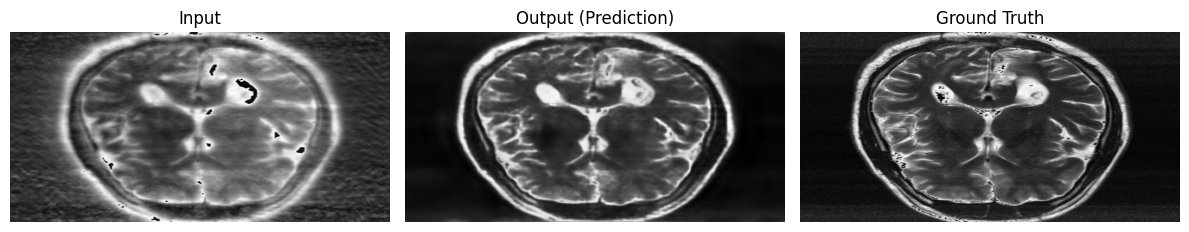

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


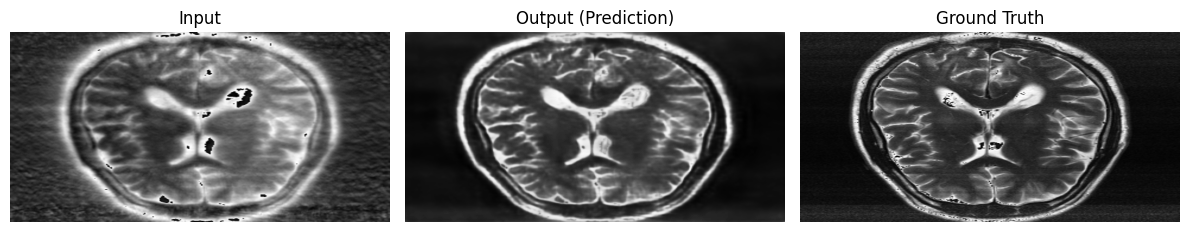

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


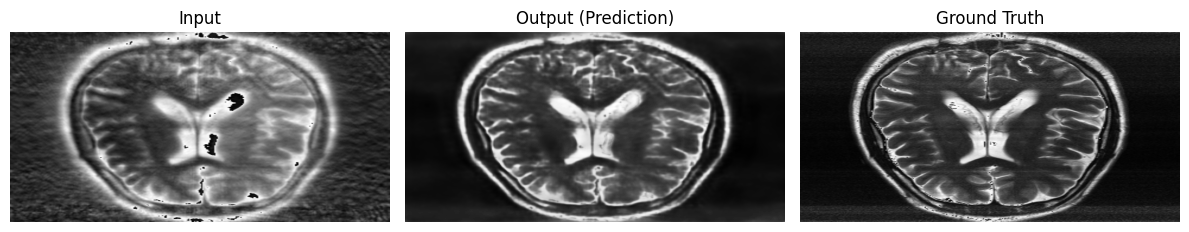

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


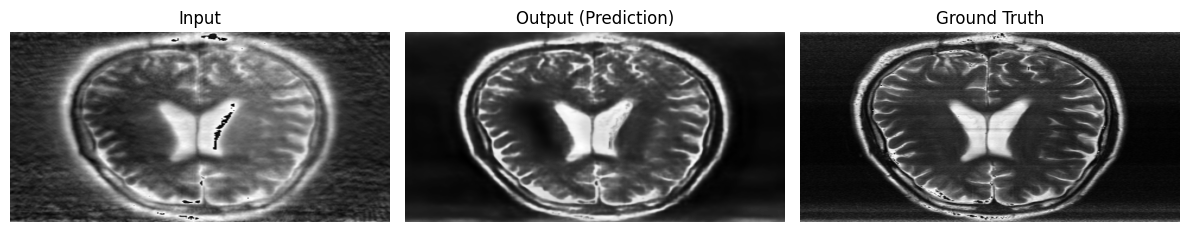

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


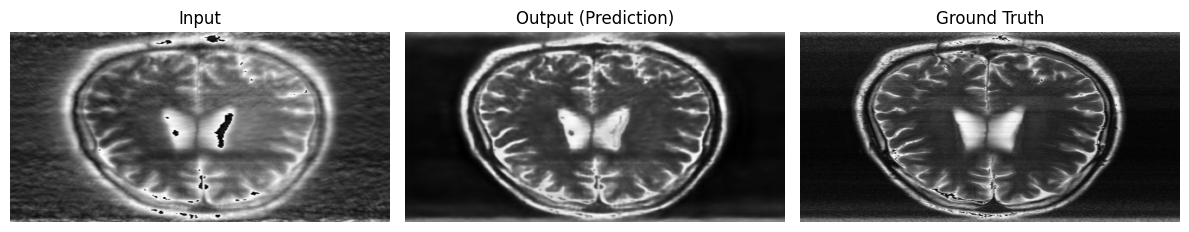

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


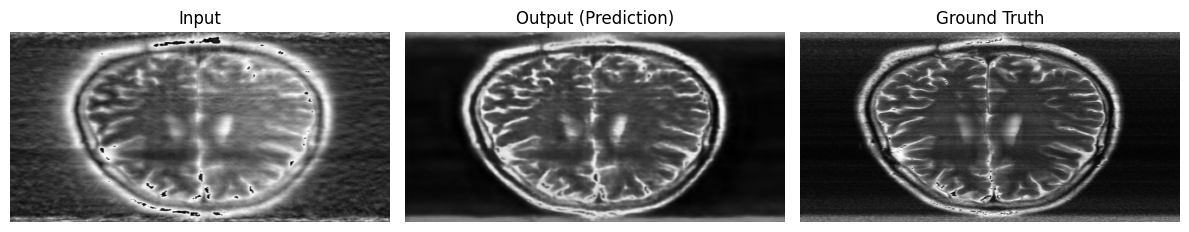

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


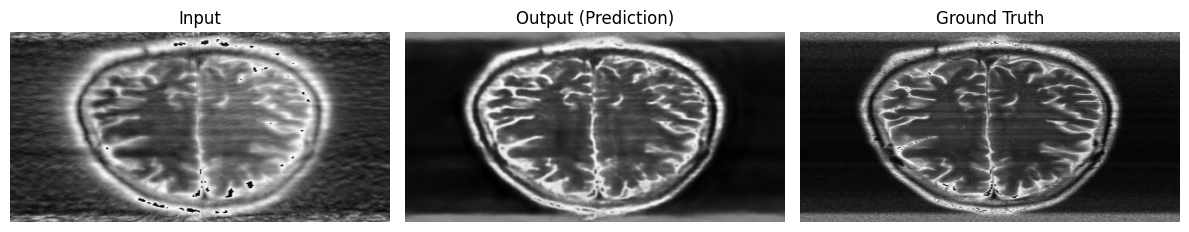

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


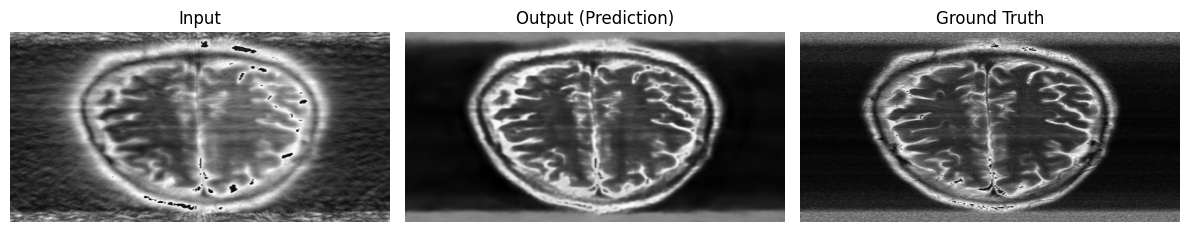

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


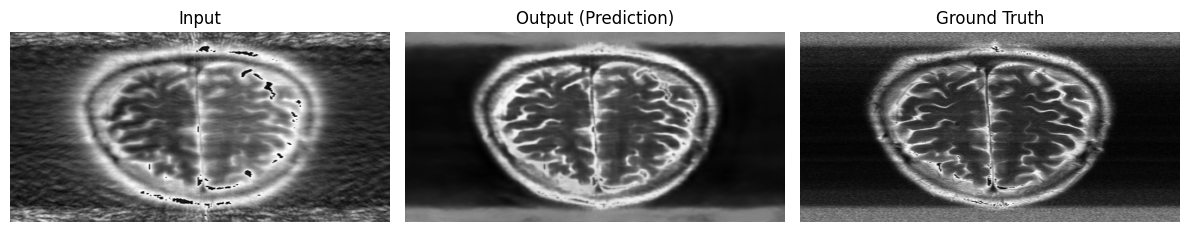

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


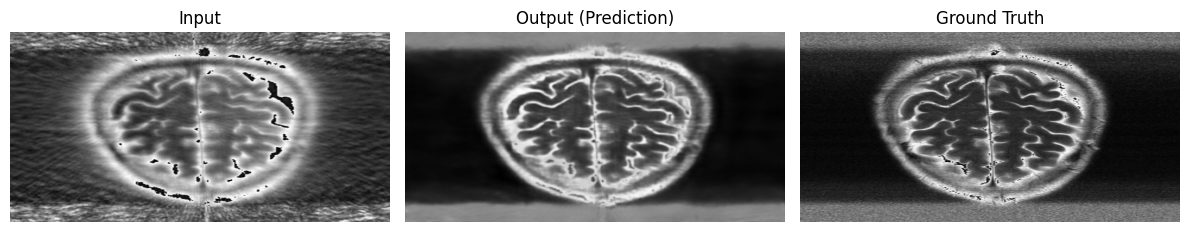

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


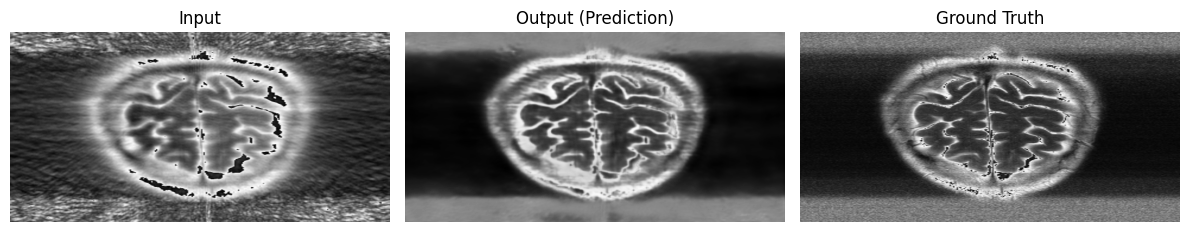

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


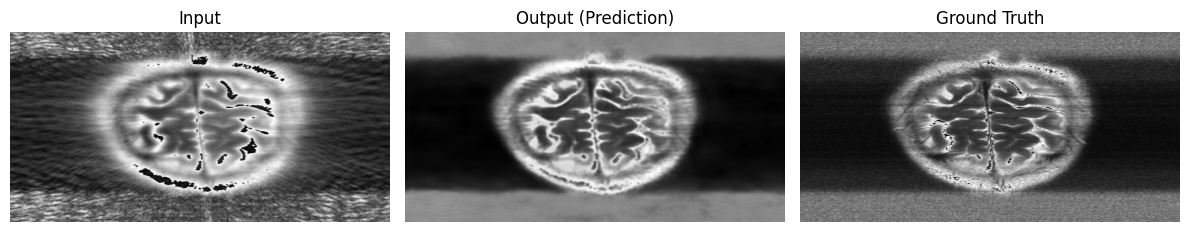

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


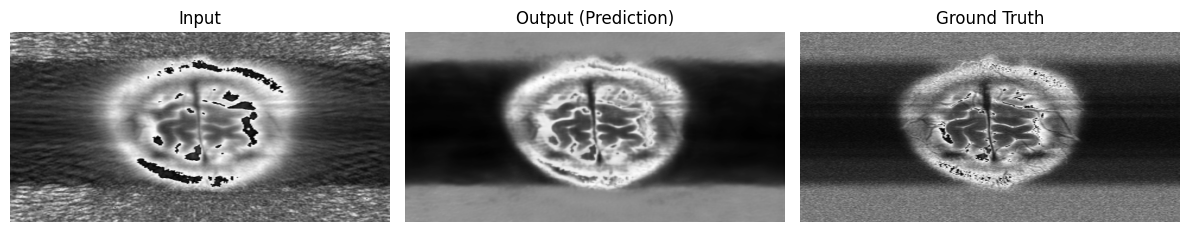

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


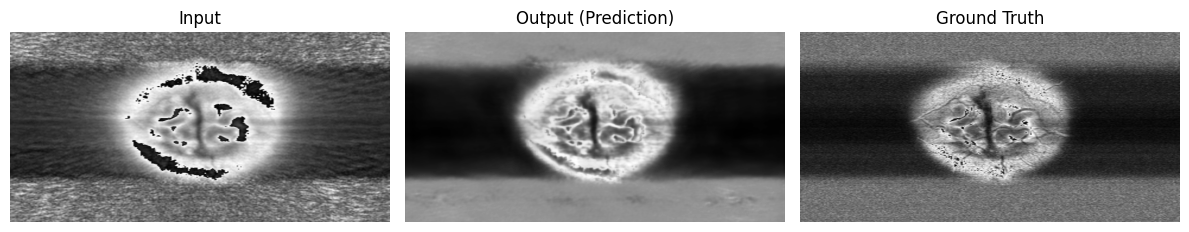

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


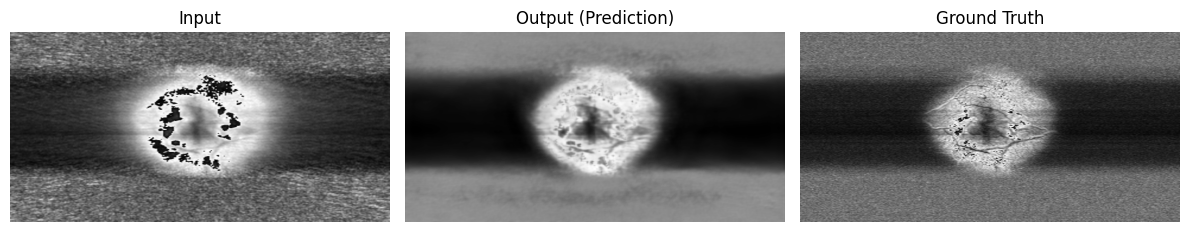

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


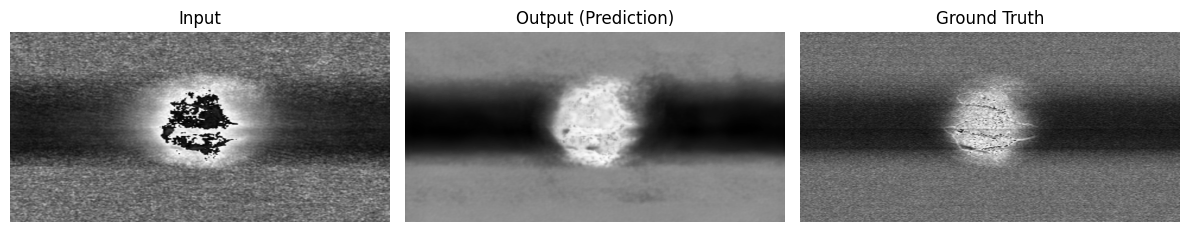

In [ ]:

for input_image_name, ground_truth_image_name in zip(input_images, ground_truth_images):
    # Load input and ground truth
    input_path = os.path.join(test_input_dir, input_image_name)
    ground_truth_path = os.path.join(test_ground_truth_dir, ground_truth_image_name)

    input_img = load_image(input_path)
    ground_truth_img = tf.image.decode_png(tf.io.read_file(ground_truth_path), channels=1)
    ground_truth_img = tf.image.resize(ground_truth_img, (320, 640))  # Ensure same size

    # Predict output
    predicted_img = model.predict(input_img)
    predicted_img_processed = post_process_image(predicted_img)

    # Display the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Input")
    plt.imshow(tf.squeeze(input_img), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Output (Prediction)")
    plt.imshow(predicted_img_processed, cmap="gray")  # Normalize for display
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Ground Truth")
    plt.imshow(tf.squeeze(ground_truth_img) / 255.0, cmap="gray") # Normalize for display
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# Paths
model_path = "/content/drive/MyDrive/final_model_3.keras"
test_input_dir = "/content/drive/MyDrive/Testing/input"
test_ground_truth_dir = "/content/drive/MyDrive/Testing/ground_truth"

In [ ]:
model = load_model(model_path, compile=False)  # No need to recompile if only predicting

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


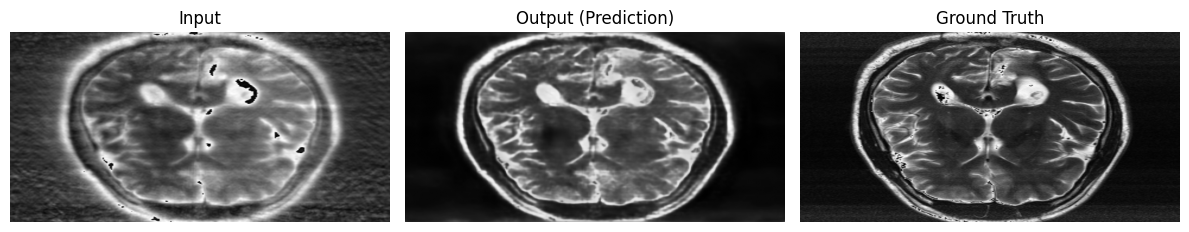

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


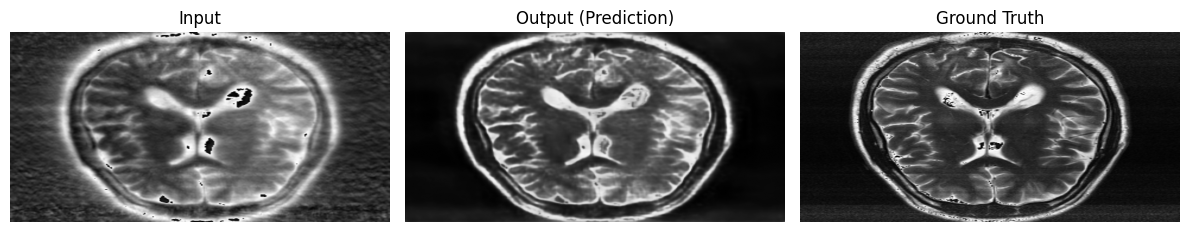

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


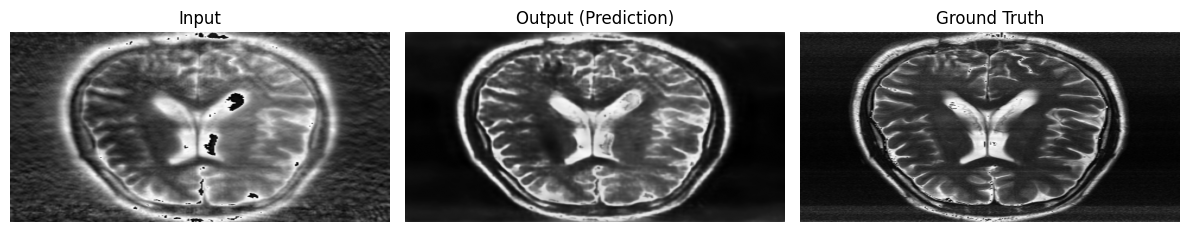

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


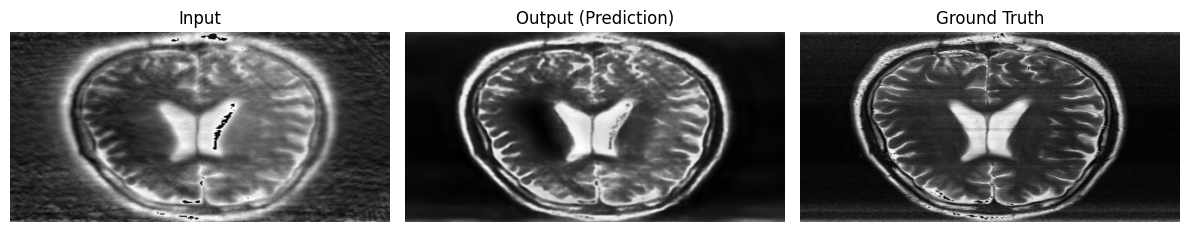

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


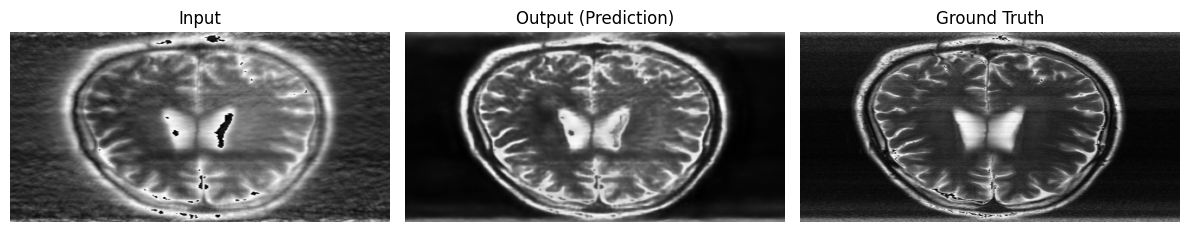

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


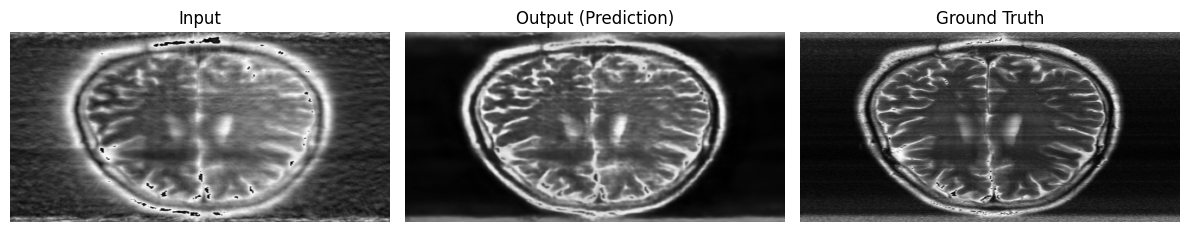

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


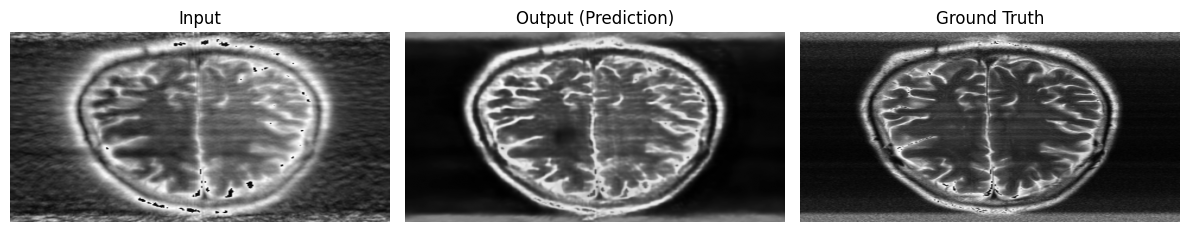

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


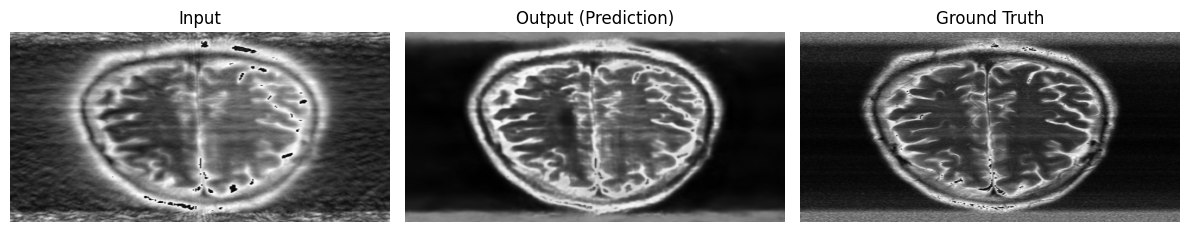

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


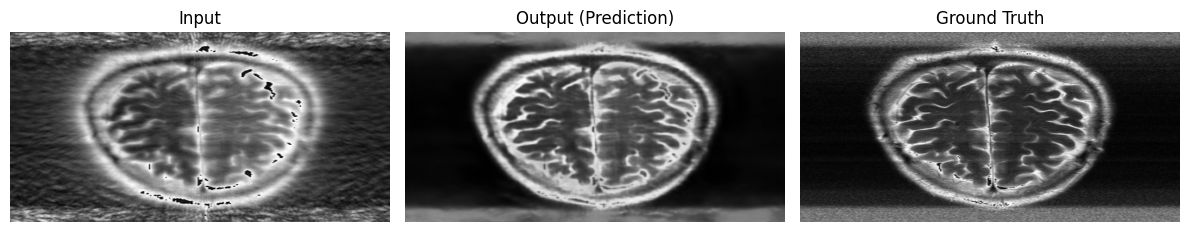

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


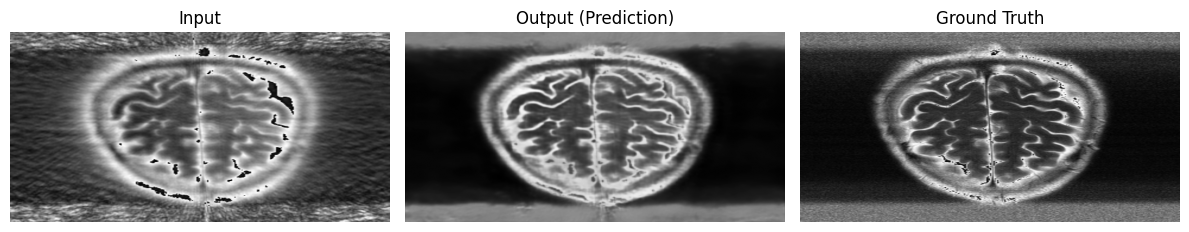

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


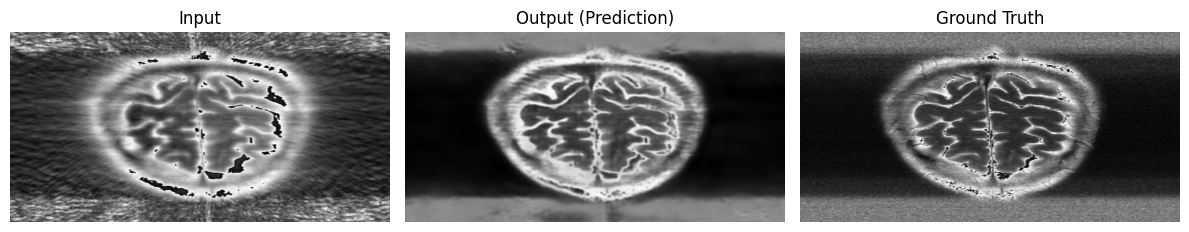

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


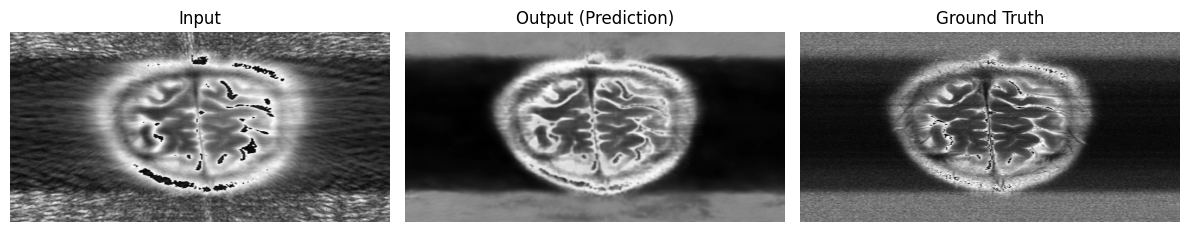

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


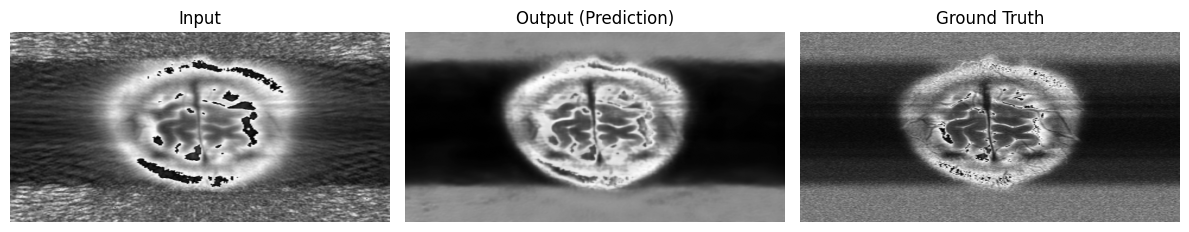

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


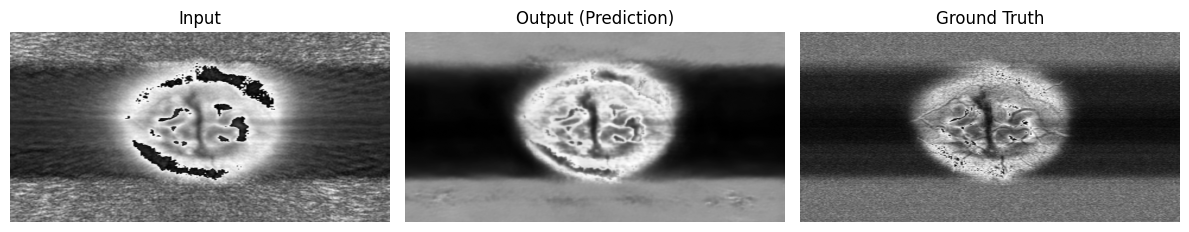

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


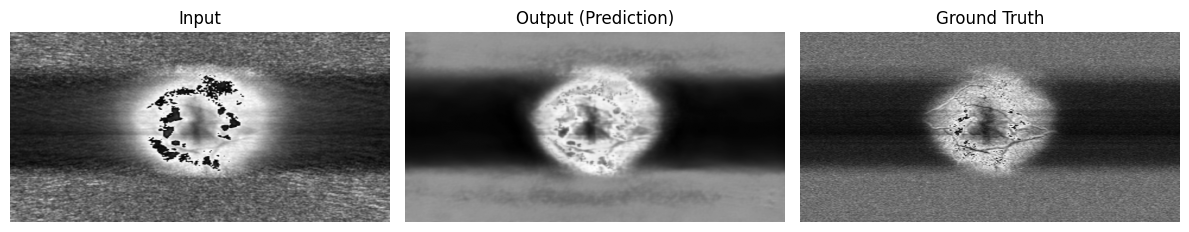

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


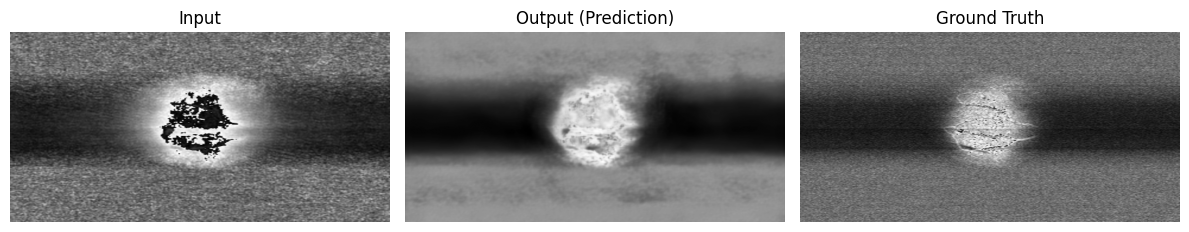

In [ ]:

# Display results
for input_image_name, ground_truth_image_name in zip(input_images, ground_truth_images):
    input_path = os.path.join(test_input_dir, input_image_name)
    ground_truth_path = os.path.join(test_ground_truth_dir, ground_truth_image_name)

    input_img = load_image(input_path)
    ground_truth_img = tf.image.decode_png(tf.io.read_file(ground_truth_path), channels=1)
    ground_truth_img = tf.image.resize(ground_truth_img, (320, 640))

   
    predicted_img = model.predict(input_img)
    predicted_img_processed = post_process_image(predicted_img)

    # Display the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title("Input")
    plt.imshow(tf.squeeze(input_img), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Output (Prediction)")
    plt.imshow(predicted_img_processed, cmap="gray")  # Normalize for display
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Ground Truth")
    plt.imshow(tf.squeeze(ground_truth_img) / 255.0, cmap="gray") # Normalize for display
    plt.axis("off")

    plt.tight_layout()
    plt.show()